In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import signal
from scipy import interpolate

from dateutil import parser

anem_str2date = lambda x: parser.parse(x.decode("utf-8"))
flight_str2data = lambda x: parser.parse(x.decode("utf-8"))

from local_utils import *

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

In [2]:
# First flight at Seal Beach
flight_filename ="Field_Experiments/Drone_Experiments/2022-06-08_17-00-17_v2.csv"
flight_data = np.genfromtxt(flight_filename, dtype=None, delimiter=',', names=True, 
                           converters = {"datetimelocal": flight_str2data})

anem_data_filename = "Field_Experiments/Drone_Experiments/WEATHER_-_2636851_Jun_8_2022_8_42_46_PM.csv"
anem_data = np.genfromtxt(anem_data_filename, dtype=None, names=True, delimiter=',', 
                          converters = {"FORMATTED_DATE_TIME": anem_str2date})

# Convert from km/hr to m/s
anem_data["Wind_Speed"] *= 0.277778

# For some reason, the anemometer doesn't record seconds. 
# Since the data are collected at 0.5 Hz, we can reconstruct the seconds.
# print(datetime("2022-06-08 17:00:45"))

# Because of the way the time conversion for the anemometers works, I have to have two separate times
min_time = datetime(2022, 6, 8, 17, 0, 0)
max_time = datetime(2022, 6, 8, 17, 2, 5)

min_plot_time = datetime(2022, 6, 8, 17, 0, 35)
max_plot_time = datetime(2022, 6, 8, 17, 2, 3)

# print(flight_data['datetimelocal'])

anem_ind = (anem_data["FORMATTED_DATE_TIME"] >= min_time) &\
        (anem_data["FORMATTED_DATE_TIME"] <= max_time)
anem_times = np.arange(np.min(anem_data["FORMATTED_DATE_TIME"][anem_ind]), 
                       np.max(anem_data["FORMATTED_DATE_TIME"][anem_ind]) + timedelta(minutes=1), 
                       timedelta(seconds=2)).astype(datetime)

tilt = calc_tilt(flight_data['pitchdeg'], flight_data['rolldeg'])

N = 100 # measurements every 0.1 of a second
filtered_tilt = np.convolve(tilt, np.ones(N)/N, mode='same')

/var/folders/gh/h5y326mn4jn844lcv0wlxs9c0000gp/T/ipykernel_1903/140891919.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  flight_data = np.genfromtxt(flight_filename, dtype=None, delimiter=',', names=True,
/var/folders/gh/h5y326mn4jn844lcv0wlxs9c0000gp/T/ipykernel_1903/140891919.py:7: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  anem_data = np.genfromtxt(anem_data_filename, dtype=None, names=True, delimiter=',',


0:00:00.100000


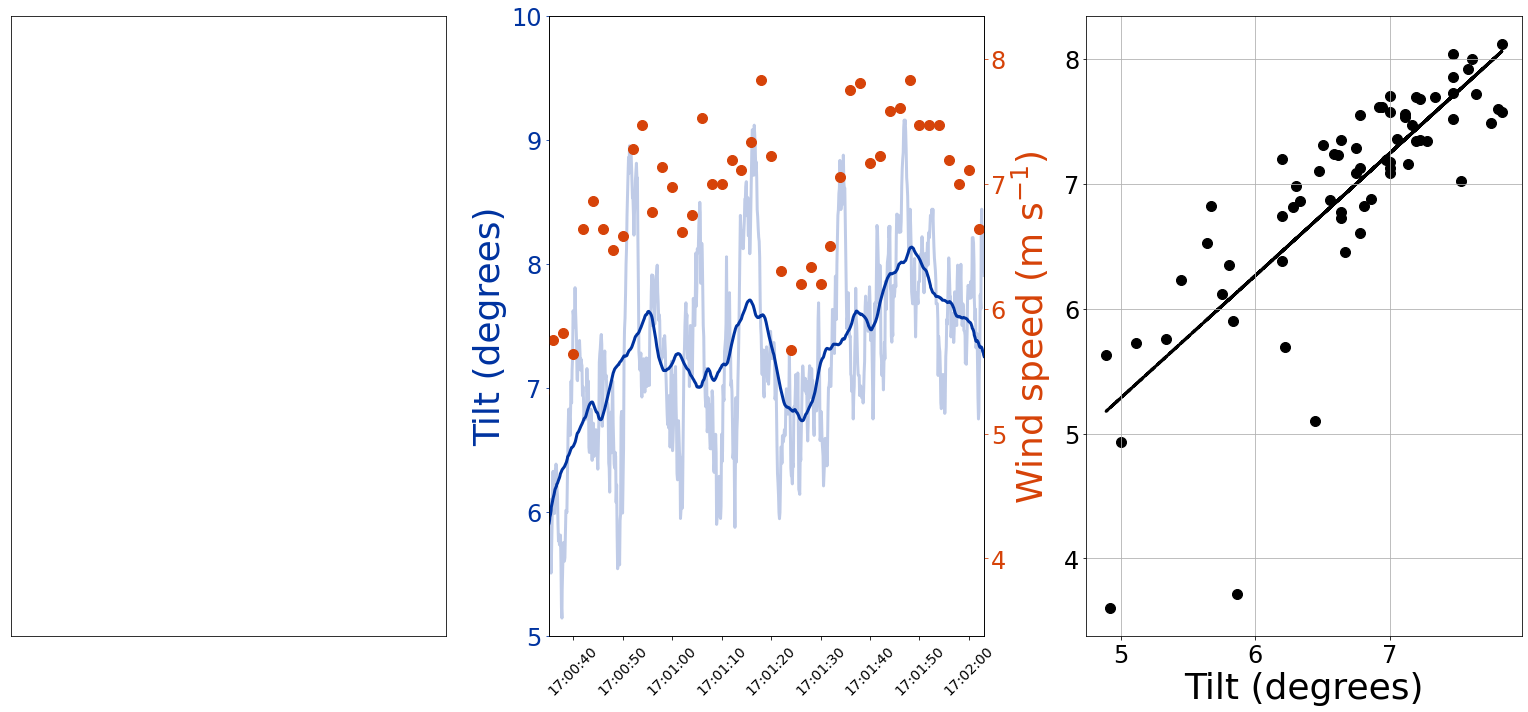

In [21]:
fig = plt.figure(figsize=(12*aspect_ratio, 10))
ax1 = fig.add_subplot(132)
ax2 = ax1.twinx()
ax3 = fig.add_subplot(133, sharey=ax2)

# For the photograph - empty out the axis labels
ax4 = fig.add_subplot(131)
ax4.get_xaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])

# plt.scatter(flight_data['datetimelocal'], filtered_tilt)

# These actually match up pretty well!
ax1.plot(flight_data['datetimelocal'], tilt, lw=3, color=BoiseState_blue, alpha=0.25)

print(np.median(flight_data['datetimelocal'][1:] - flight_data['datetimelocal'][:-1]))

# ax1.plot(flight_data['datetimelocal'], flight_data['yawdeg'], lw=3, color='green')
ax1.plot(flight_data['datetimelocal'], filtered_tilt, lw=3, color=BoiseState_blue)
ax2.scatter(anem_times, anem_data["Wind_Speed"][anem_ind], color=BoiseState_orange, s=100)

ax1.set_ylabel("Tilt (degrees)", fontsize=36, color=BoiseState_blue)
ax2.set_ylabel(r'Wind speed (${\rm m\ s^{-1}}$)', fontsize=36, color=BoiseState_orange)
ax2.tick_params(axis='y', colors=BoiseState_orange, labelsize=24)
ax1.tick_params(axis='y', colors=BoiseState_blue)
ax1.tick_params(axis='x', labelsize=14)
for label in ax1.get_xticklabels():
  label.set_rotation(45)
ax1.tick_params(axis='y', labelsize=24)
# ax1.text(0.025, 0.9, "(a)", fontsize=64, transform=ax1.transAxes)

### Interpolated Tilt ####

# Convert times to float array
flight_time_delta =\
    np.array([(flight_data['datetimelocal'][i] - flight_data['datetimelocal'][0]).seconds +\
              (flight_data['datetimelocal'][i] - flight_data['datetimelocal'][0]).microseconds/1e6
              for i in range(len(flight_data['datetimelocal']))])
anem_time_delta = \
    np.array([(anem_times[i] - flight_data['datetimelocal'][0]).seconds +\
              (anem_times[i] - flight_data['datetimelocal'][0]).microseconds/1e6
              for i in range(len(anem_times))])

# For some reason, python thinks these time stamps are one day apart...
# print(flight_data['datetimelocal'][0], anem_times[0], (anem_times[0] - flight_data['datetimelocal'][0]))

# Interpolate flight data to anemometer times
interpolated_filtered_tilt = np.interp(anem_time_delta, flight_time_delta, filtered_tilt)

x = anem_data["Wind_Speed"][anem_ind]
y = interpolated_filtered_tilt

# Interpolation goofs up beyond this because there are no tilt points
oind = anem_time_delta < 134
x = x[oind]
y = y[oind]

ax3.scatter(x, y, marker='o', s=100, color='k')
ax3.plot(x, np.polyval(np.polyfit(x, y, 1), x), lw=3, ls='--', color='k', zorder=-1)

# ax3.yaxis.tick_right()
# ax3.yaxis.set_label_position("right")
ax3.set_xlabel("Tilt (degrees)", fontsize=36)
ax3.tick_params(labelsize=24)
ax3.grid(True)
# ax3.text(0.025, 0.9, "(b)", fontsize=64, transform=ax3.transAxes)

# plt.xlim([20000, 100000])
ax1.set_xlim([min_plot_time, max_plot_time])
ax1.set_ylim([5, 10])

plt.tight_layout()

fig.savefig("example_tilt_and_windspeed.jpg", dpi=300, bbox_inches='tight')

10.004
[86382.094 86384.094 86386.094 86388.094 86390.094 86392.094 86394.094
 86396.094 86398.094   134.094   136.094   138.094   140.094   142.094
   144.094   146.094   148.094   150.094   152.094   154.094   156.094
   158.094   160.094]


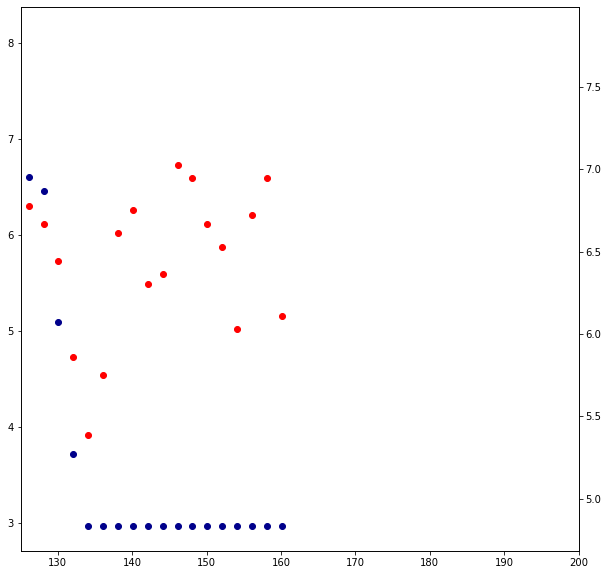

In [21]:
# Convert times to float array
flight_time_delta =\
    np.array([(flight_data['datetimelocal'][i] - flight_data['datetimelocal'][0]).seconds +\
              (flight_data['datetimelocal'][i] - flight_data['datetimelocal'][0]).microseconds/1e6
              for i in range(len(flight_data['datetimelocal']))])
anem_time_delta = \
    np.array([(anem_times[i] - flight_data['datetimelocal'][0]).seconds +\
              (anem_times[i] - flight_data['datetimelocal'][0]).microseconds/1e6
              for i in range(len(anem_times))])

# For some reason, python thinks these time stamps are one day apart...
# print(flight_data['datetimelocal'][0], anem_times[0], (anem_times[0] - flight_data['datetimelocal'][0]))

# Interpolate flight data to anemometer times
interpolated_filtered_tilt = np.interp(anem_time_delta, flight_time_delta, filtered_tilt)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

print(flight_time_delta[100])
ax1.scatter(anem_time_delta, interpolated_filtered_tilt, color="darkblue")
ax2.scatter(anem_time_delta, anem_data["Wind_Speed"][anem_ind], color="red")

# plt.xlim([20000, 100000])
# plt.xlim([flight_time_delta[0], flight_time_delta[-1]])
plt.xlim([125, 200])

ind = interpolated_filtered_tilt < 3
print(anem_time_delta[ind])

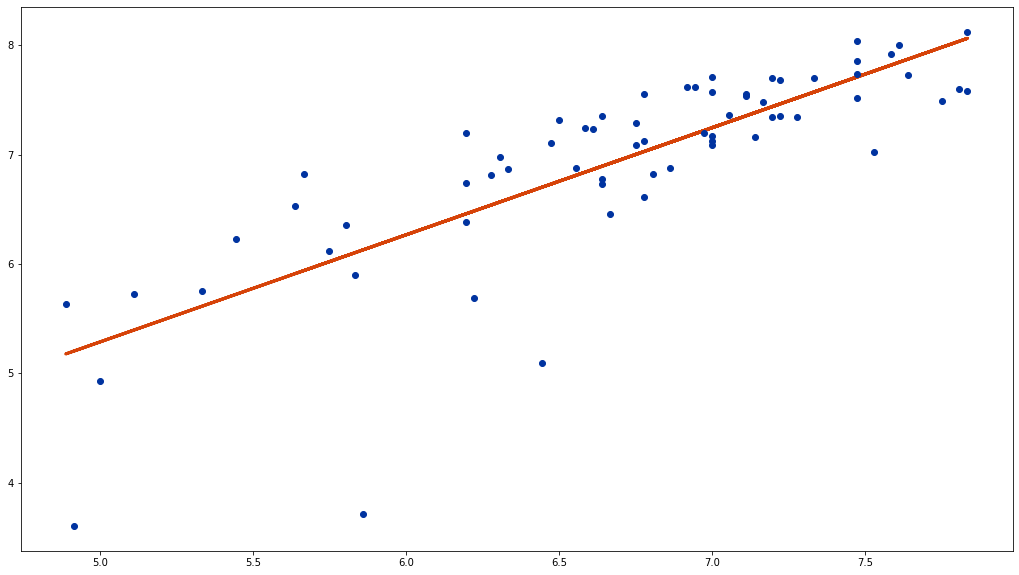

In [25]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

x = anem_data["Wind_Speed"][anem_ind]
y = interpolated_filtered_tilt

# Filter out some outliers - These points seem spurious
oind = anem_time_delta < 134
plot_time = anem_time_delta[oind]
x = x[oind]
y = y[oind]

ax.scatter(x, y, color=BoiseState_blue)
ax.plot(x, np.polyval(np.polyfit(x, y, 1), x), lw=3, color=BoiseState_orange, zorder=-1)

ax.grid(True)
ax.set_xlabel("Tilt (degrees)", fontsize=36, color=BoiseState_blue)
ax.set_ylabel("Tilt (degrees)", fontsize=36, color=BoiseState_blue)
ax.tick_params(labelsize=24)